In [1]:
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

DATASET_PATH = os.path.normpath('../datasets/MANNERSDB/all_data.csv')
INDEX_COL = 'Stamp'

## Data analysis

In [2]:
df = pd.read_csv(DATASET_PATH)

In [3]:
#Check for no nulls
nulls = df.isnull().sum().sum()
print(f"Null values: {'✅ None' if nulls == 0 else f'❌ {nulls} total'}")
if nulls > 0:
    print(" Columns with nulls:", df.columns[df.isnull().any()].tolist())

Null values: ✅ None


In [4]:
#Check for index continuity
expected_indices = set(range(250, 1000))
actual_indices = set(df[INDEX_COL])
missing = sorted(expected_indices - actual_indices)
extra = sorted(actual_indices - expected_indices)
status = '✅ Complete' if not missing and not extra else '❌ Issues'
print(f"Indices (250-999): {status}")
if missing: print(f"  Missing: {len(missing)} indices (e.g., {missing[:3]})")
if extra: print(f"  Extra: {len(extra)} indices (e.g., {extra[:3]})")

Indices (250-999): ✅ Complete


In [5]:
#Check for likert scores validity
labels = df.iloc[:, -8:]
out_of_range = (labels < 1) | (labels > 5)
print(f"Likert scores out of range 1-5: {'✅ None' if out_of_range.any().sum() == 0 else '❌ {out_of_range.any().sum()} out of range values'}")
if out_of_range.any().sum() != 0:
    print (f"  Rows with out of range Likert values: \n {df[out_of_range.any(axis=1)]}")

Likert scores out of range 1-5: ✅ None


In [6]:
# Check if all indices have exactly 15 entries
entry_counts = df[INDEX_COL].value_counts()
entry_distribution = entry_counts.value_counts().sort_index()
total_indices = len(entry_counts)
entry_distribution_pct = entry_distribution / total_indices * 100

bad_counts = entry_counts[entry_counts != 15]
print(f"Entries per index: {'✅ All 15' if bad_counts.empty else '❌ Irregular'}")
if not bad_counts.empty:
    print(f"  {len(bad_counts)} indices have wrong counts (e.g., {dict(bad_counts.head(3))})")

Entries per index: ❌ Irregular
  531 indices have wrong counts (e.g., {320: np.int64(34), 322: np.int64(34), 321: np.int64(33)})


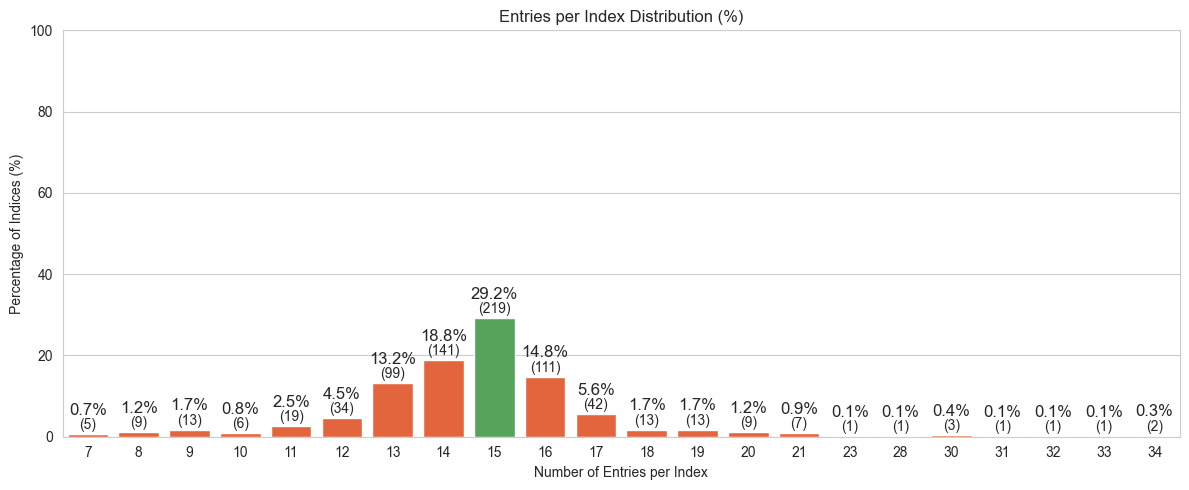

In [7]:
df_plot = pd.DataFrame({
    'x': entry_distribution.index.astype(str),
    'y': entry_distribution_pct.values,
    'abs': entry_distribution.values
})
df_plot['color'] = ['#4CAF50' if int(x) == 15 else '#FF5722' for x in df_plot['x']]

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df_plot,
    x='x', y='y',
    hue='x',  # Redundant, but required for palette coloring
    palette=df_plot.set_index('x')['color'].to_dict(),
    legend=False
)
plt.title('Entries per Index Distribution (%)')
plt.xlabel('Number of Entries per Index')
plt.ylabel('Percentage of Indices (%)')
plt.ylim(0, 100)
for i, (pct, abs_val) in enumerate(zip(df_plot['y'], df_plot['abs'])):
    ax.text(i, pct + max(2, 0.04 * 100), f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)
    ax.text(i, pct + max(0.5, 0.005 * 100), f'({abs_val})', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
#Check for duplicates
duplicated_rows = df.duplicated(keep=False)
duplicates_per_index = duplicated_rows.groupby(df['Stamp']).sum()
duplicates_per_index = duplicates_per_index.apply(lambda x: max(x - 1, 0))

duplicate_distribution = duplicates_per_index.value_counts().sort_index()
duplicate_distribution_pct = duplicate_distribution / total_indices * 100

if duplicate_distribution.drop(0, errors='ignore').sum() == 0:
    print("\nDuplicate rows: ✅ None found per index.")
else:
    print(f"Duplicate rows: ❌ Duplicates found for {int((duplicates_per_index > 0).sum())} indices.")
    print("  Indices with duplicates (first 5):", duplicates_per_index[duplicates_per_index > 0].index.tolist()[:5])

Duplicate rows: ❌ Duplicates found for 435 indices.
  Indices with duplicates (first 5): [250, 254, 257, 259, 261]


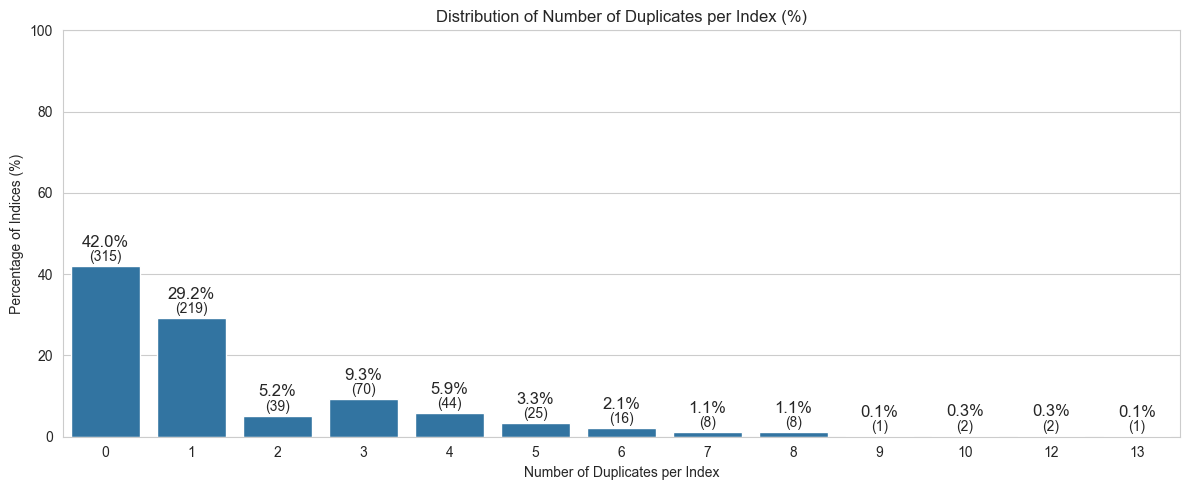

In [9]:
dup_plot = pd.DataFrame({
        'x': duplicate_distribution.index.astype(str),
        'y': duplicate_distribution_pct.values,
        'abs': duplicate_distribution.values
    })

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=dup_plot,
    x='x', y='y'
)
plt.title('Distribution of Number of Duplicates per Index (%)')
plt.xlabel('Number of Duplicates per Index')
plt.ylabel('Percentage of Indices (%)')
plt.ylim(0, 100)
for i, (pct, abs_val) in enumerate(zip(dup_plot['y'], dup_plot['abs'])):
    ax.text(i, pct + max(2, 0.04 * 100), f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)
    ax.text(i, pct + max(0.5, 0.005 * 100), f'({abs_val})', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## Training data preparation

In [10]:
def load_and_aggregate(csv_path):
    df = pd.read_csv(csv_path)
    agg = df.groupby(INDEX_COL).agg({
        **{col: 'first' for col in df.columns[1:30]},
        **{col: 'mean' for col in df.columns[30:38]}
    }).reset_index()
    return agg

In [11]:
def split_dataframe(df, val_size=0.15, test_size=0.15, random_state=42):
    indices = df[INDEX_COL].unique()
    train_idx, temp_idx = train_test_split(indices, test_size=val_size + test_size, random_state=random_state)
    val_idx, test_idx = train_test_split(temp_idx, test_size=test_size/(val_size + test_size), random_state=random_state)
    
    train_df = df[df[INDEX_COL].isin(train_idx)]
    val_df = df[df[INDEX_COL].isin(val_idx)]
    test_df = df[df[INDEX_COL].isin(test_idx)]
    return train_df, val_df, test_df

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.feature_cols = list(self.df.columns[1:30])
        self.label_cols = list(self.df.columns[30:38])
        self.transform = transform

    def __getitem__(self, idx):
        x = self.df.loc[idx, self.feature_cols].values.astype('float32')
        y = self.df.loc[idx, self.label_cols].values.astype('float32')
        if self.transform:
            x = self.transform(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

In [13]:
agg_df = load_and_aggregate(DATASET_PATH)
train_df, val_df, test_df = split_dataframe(agg_df)

#Define transformations
scaler = StandardScaler().fit(train_df.iloc[:, 1:30].values.astype('float32'))
transform = lambda x: scaler.transform(x.reshape(1, -1)).flatten()

train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
